In [1]:
import cv2
import os
from tqdm.notebook import tqdm_notebook as tqdm
from PIL import Image as Im
from IPython.display import display, Image, clear_output
from PIL import Image as Im
import time
import datetime

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchsummary import summary
from tqdm.notebook import tqdm
import torchvision.models as models
from torchmetrics import F1Score as F1

C:\Users\user\anaconda3\envs\TORCH\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [3]:
def seed_everything(seed):
    random.seed(seed) # фиксируем генератор случайных чисел
    #os.environ['PYTHONHASHSEED'] = str(seed) # фиксируем заполнения хешей
    np.random.seed(seed) # фиксируем генератор случайных чисел numpy
    torch.manual_seed(seed) # фиксируем генератор случайных чисел pytorch
    torch.cuda.manual_seed(seed) # фиксируем генератор случайных чисел для GPU
    torch.backends.cudnn.benchmark = True #включение cuDNN Autotuner
    #отключение отладок
    torch.autograd.set_detect_anomaly(False)
    torch.autograd.profiler.profile(False)
    torch.autograd.profiler.emit_nvtx(False)
seed_everything(42)
device = f"cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Потоковое чтение кадров с любой доступрнйо камеры

In [4]:
# cap = cv2.VideoCapture(0) #0 - выбрать любую доступную камеру..  
# while True:
#         ret, frame = cap.read()
#         if not ret:
#             break

#         # Применяем операции обработки кадра - переворачиваем его по вертикали
#         frame = cv2.flip(frame, 1)

#         # Отображаем кадр
#         #display(Image.fromarray(frame)
#cap.release()

Нарезка видео на кадры 

In [5]:
# # Укажите путь к папке с видеофайлами
# video_folder = r'I:\Хакатоны\Цифровой прорыв РЖД\train_dataset_Безопасный маршрут\боковая камера\Новая папка'

# # Укажите папку для сохранения кадров
# output_folder = r'I:\out1'

# # Получаем список файлов в папке
# video_files = [f for f in os.listdir(video_folder) if f.endswith('.mp4')]

# # Создаем папку для сохранения кадров, если она не существует

# out = 70
# count = 70
# # Цикл для обработки каждого видео
# for video_file in tqdm(video_files):
#     video_path = os.path.join(video_folder, video_file)
#     cap = cv2.VideoCapture(video_path)

#     # Проверяем, успешно ли открылся видеофайл
#     if cap.isOpened():
#         print(f"Открыт видеофайл {video_file}.")

#     frame_count = 0

#     while True:
#         ret, frame = cap.read()
#         if not ret:
#             break

#         if frame_count % int(cap.get(cv2.CAP_PROP_FPS)) == 0:

#             frame_path = f'{output_folder}/{out:04d}_frame_{frame_count:04d}.png'
            
#             # Преобразуем кадр к размеру 224x224
#             frame_resized = cv2.resize(frame, (224, 224))

#             # Преобразуем кадр в RGB формат перед сохранением
#             #frame_rgb = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2RGB)
#             cv2.imwrite(frame_path, frame_resized)
#             count +=1

#         frame_count += 1
#     out += 1
#     cap.release()

# print(f"Всего сохранено кадров: {count}")
# cap.release()

In [6]:
#функиия преобразования фоток к нужному размеру
def process_images_in_folder(folder_path):
    for root, dirs, files in os.walk(folder_path):
        for file_name in files:
            if file_name.lower().endswith('.png'):
                file_path = os.path.join(root, file_name)
                try:
                    with Im.open(file_path) as img:
                        img = img.resize((224, 224), Im.ANTIALIAS)
                        img.save(file_path)
                        print(f"Processed: {file_path}")
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")

# Путь к корневой папке, в которой находятся ваши изображения
#root_folder = r'I:\Хакатоны\Цифровой прорыв РЖД\Новая папка'
#process_images_in_folder(root_folder)


Подбор модели

In [7]:
# создадим датест имеющих файлов
# Разметка по классам:
# 0-помехи отсутсвуют
# 1- помехи отсутсвуют

def create_dataframe(folder_path):
    data = []

    for root, dirs, files in os.walk(folder_path):
        
        for file in files:
            folder_name = os.path.basename(root)
            file_path = os.path.join(root, file)
            data.append((folder_name, file_path))

    df = pd.DataFrame(data, columns=['Folder Name', 'File Path'])
    return df

# Пример использования
folder_path = r"I:\Хакатоны\Цифровой прорыв РЖД\Набор_кадров"
df = create_dataframe(folder_path)

# Вывести первые несколько строк датафрейма
df.head()

,Folder Name,File Path
0,0,I:\Хакатоны\Цифровой прорыв РЖД\Набор_кадров\0...
1,0,I:\Хакатоны\Цифровой прорыв РЖД\Набор_кадров\0...
2,0,I:\Хакатоны\Цифровой прорыв РЖД\Набор_кадров\0...
3,0,I:\Хакатоны\Цифровой прорыв РЖД\Набор_кадров\0...
4,0,I:\Хакатоны\Цифровой прорыв РЖД\Набор_кадров\0...


<Axes: >

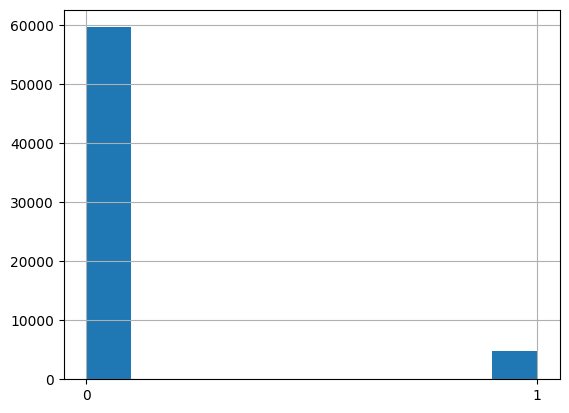

In [8]:
df['Folder Name'].hist()

In [9]:
df['Folder Name'] = df['Folder Name']
df['Folder Name'].unique()

array(['0', '1'], dtype=object)

In [10]:
df.value_counts()

Folder Name  File Path                                                          
0            I:\Хакатоны\Цифровой прорыв РЖД\Набор_кадров\0\0000_frame_0000.png     1
             I:\Хакатоны\Цифровой прорыв РЖД\Набор_кадров\0\╨д╨░╨╕╠Ж╨╗ 10757.png    1
             I:\Хакатоны\Цифровой прорыв РЖД\Набор_кадров\0\╨д╨░╨╕╠Ж╨╗ 10745.png    1
             I:\Хакатоны\Цифровой прорыв РЖД\Набор_кадров\0\╨д╨░╨╕╠Ж╨╗ 10746.png    1
             I:\Хакатоны\Цифровой прорыв РЖД\Набор_кадров\0\╨д╨░╨╕╠Ж╨╗ 10747.png    1
                                                                                   ..
             I:\Хакатоны\Цифровой прорыв РЖД\Набор_кадров\0\0007_frame_37230.png    1
             I:\Хакатоны\Цифровой прорыв РЖД\Набор_кадров\0\0007_frame_37260.png    1
             I:\Хакатоны\Цифровой прорыв РЖД\Набор_кадров\0\0007_frame_37290.png    1
             I:\Хакатоны\Цифровой прорыв РЖД\Набор_кадров\0\0007_frame_37320.png    1
1            I:\Хакатоны\Цифровой прорыв РЖД\Набор_кадров\1

Параметры фцнкции обучения

In [11]:
batch_size = 32 #размер батча
num_epochs = 10 #количество эпох
lr = 0.001 #шаг оптимизатора
num_classes = 2 #количество классов

Создадим датасет для обучения

In [12]:
class CustomDataset(Dataset):
    def __init__(self, csv_file_path, transform=None):
        self.csv_data = csv_file_path
        self.transform = transform

    def __len__(self):
        return len(self.csv_data)

    def __getitem__(self, index):
        image_filename = self.csv_data.iloc[index, 1]
        class_label = self.csv_data.iloc[index, 0]

        # Полный путь к файлу изображения
        image_path = os.path.join(image_filename)
        image = Im.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(int(class_label))

In [16]:
# Трансформации для изображений
# data_transform = transforms.Compose([
#     #transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])
data_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.75, 1.3333333333333333)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# Создание экземпляра датасета
custom_dataset = CustomDataset(df, transform=data_transform)

# Разделение на тренировочный и валидационный наборы с учетом дисбаланса классов
validation_split = 0.2
dataset_size = len(custom_dataset)
validation_size = int(validation_split * dataset_size)
train_size = dataset_size - validation_size

# Получение индексов для разделения
indices = list(range(dataset_size))
random.shuffle(indices)  # Перемешиваем индексы перед разделением
train_indices, validation_indices = indices[:train_size], indices[train_size:]

# Создание DataLoader для тренировочного и валидационного наборов
num_workers = torch.multiprocessing.cpu_count()  # Использование всех доступных ядер
train_loader = DataLoader(custom_dataset, batch_size=batch_size, sampler=train_indices, pin_memory=True)
valid_loader = DataLoader(custom_dataset, batch_size=batch_size, sampler=validation_indices, pin_memory=True)

Функция обучения

In [17]:
def train_model(model, num_epochs, train_loader, valid_loader, device, lr):
    model = model.to(device)
    # Определение функции потерь и оптимизатора
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    f1_metric = F1(task="multiclass", num_classes=num_classes).to(device)  # num_classes - количество классов

    for epoch in range(num_epochs):
        start_time = time.time()  # Засекаем время начала эпохи
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            for param in model.parameters():
                param.grad = None
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            # Обновляем метрику F1
            f1_metric.update(predicted, labels)

        epoch_duration = time.time() - start_time
        f1_metric.reset()  # Сбрасываем метрику для следующей эпохи

        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                # Обновляем метрику F1

                _, predicted = torch.max(outputs.data, 1)
                total_samples += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()

                f1_metric.update(predicted, labels)

        # Получаем значение F1-меры
        f1_value = f1_metric.compute()


        print(f"Epoch {epoch + 1} | Train_Loss: {running_loss / len(train_loader):.4f} | Valid_Loss: {valid_loss / len(valid_loader):.4f} | F1 Score: {f1_value:.4f} | Time: {epoch_duration:.2f} seconds")

# Архитектуры с предобученными весами

## Архитектура EfficientNet

Предобученая архитектура EfficientNet-B0 из библиотеки torchvision

In [18]:
class EfficientNetB0(nn.Module):
    def __init__(self, num_classes=num_classes, weights="EfficientNet_B0_Weights.IMAGENET1K_V1"):
        super(EfficientNetB0, self).__init__()
        self.efficientnet = models.efficientnet_b0(weights=weights)
        self.linear_layer = nn.Linear(1000, num_classes)

    def forward(self, x):

        x = self.efficientnet(x)
        x = self.linear_layer(x)
        return x

efficient = EfficientNetB0()
efficient = efficient.to(device)

train_model(efficient, num_epochs, train_loader, valid_loader, device, lr)

Epoch 1 | Train_Loss: 0.1434 | Valid_Loss: 0.1023 | F1 Score: 0.9700 | Time: 648.55 seconds
Epoch 2 | Train_Loss: 0.0948 | Valid_Loss: 0.0706 | F1 Score: 0.9782 | Time: 596.04 seconds
Epoch 3 | Train_Loss: 0.0796 | Valid_Loss: 0.0795 | F1 Score: 0.9751 | Time: 587.41 seconds
Epoch 4 | Train_Loss: 0.0703 | Valid_Loss: 0.0638 | F1 Score: 0.9802 | Time: 597.98 seconds
Epoch 5 | Train_Loss: 0.0655 | Valid_Loss: 0.0597 | F1 Score: 0.9822 | Time: 599.89 seconds
Epoch 6 | Train_Loss: 0.0606 | Valid_Loss: 0.0571 | F1 Score: 0.9828 | Time: 604.15 seconds
Epoch 7 | Train_Loss: 0.0567 | Valid_Loss: 0.0479 | F1 Score: 0.9849 | Time: 603.15 seconds
Epoch 8 | Train_Loss: 0.0533 | Valid_Loss: 0.0553 | F1 Score: 0.9829 | Time: 599.64 seconds
Epoch 9 | Train_Loss: 0.0501 | Valid_Loss: 0.0678 | F1 Score: 0.9815 | Time: 653.17 seconds
Epoch 10 | Train_Loss: 0.0484 | Valid_Loss: 0.0482 | F1 Score: 0.9849 | Time: 633.12 seconds


In [44]:
#сохраняем веса модели
efficient = efficient.to('cpu')
torch.save(efficient.state_dict(), 'efficient_weights.pth')

In [47]:
#загрузка весов модели
efficient_train = EfficientNetB0()
efficient_train.load_state_dict(torch.load('efficient_weights.pth'))
efficient_train.eval()

EfficientNetB0(
  (efficientnet): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              

In [ ]:
# Получаем словарь с весами
#weights = efficient.state_dict()
# Сохраняем словарь в файл
#torch.save(weights, r'I:\Хакатоны\Цифровой прорыв РЖД\Веса\efficient_weights.pth')

Имитация работы системы

In [61]:
model = efficient_train
def simulation_system(path, model):
    # Инициализация переменных и шрифта
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    font_thickness = 2

    # Измерение скорости считывания кадров
    start_time = time.time()
    frame_count = 0
    predicted = 0
    frame_rate = 0
    model.eval().to('cuda')
    cap = cv2.VideoCapture(path)
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Не удалось считать кадр. Возможно, поток закончился.")
            break
        
        if frame_count % int(cap.get(cv2.CAP_PROP_FPS)) == 0:
            
            frame_resized = cv2.resize(frame, (224, 224))
            input_frame = transform(frame_resized)
            # Добавьте размерность батча
            input_frame = input_frame.unsqueeze(0).to('cuda')
            with torch.no_grad():
                outputs = model(input_frame)
                predicted = torch.argmax(outputs).to('cpu').item()   

        frame_count += 1

        # Вычисление и вывод скорости считывания кадров
        if frame_count % 10 == 0:
            end_time = time.time()
            elapsed_time = end_time - start_time
            frame_rate = 10 / elapsed_time  # Обновлять каждые 10 кадров
            start_time = end_time
        
        font_color = (0, 0, 255)  # Reed color in BGR    
        text = f'Class {str(predicted)} | FPS: {frame_rate:.2f}'
        cv2.putText(frame, text, (30, 30), font, font_scale, font_color, font_thickness)

        _, buffer = cv2.imencode('.jpg', frame)
        img = Image(data=buffer)
        display(img)
        clear_output(wait=True)



In [63]:
path = 'I://00_21_23short.mp4'
simulation_system(path, model)

Не удалось считать кадр. Возможно, поток закончился.


## Submission

In [64]:
def find_first_1_after_0(lst):
    result = []
    found_0 = False

    for i, num in enumerate(lst):
        if num == 0:
            found_0 = True
        elif num == 1 and found_0:
            result.append(i)
            found_0 = False

    return result


def seconds_to_mmss(seconds):
    minutes = seconds // 60
    seconds = seconds % 60
    return f"{minutes:02d}:{seconds:02d}"

In [101]:
# Укажите путь к папке с видеофайлами
video_folder = r'I:\Хакатоны\Цифровой прорыв РЖД\test'
# наименование модели
model = efficient

def simulation_system(video_folder, model):
        df_sub = pd.DataFrame(columns=['filename', 'cases_count', 'timestamps'])
        # Получаем список файлов в папке
        video_files = [f for f in os.listdir(video_folder) if f.endswith('.mp4')]
        # Цикл для обработки каждого видео
        for video_file in tqdm(video_files):
            video_path = os.path.join(video_folder, video_file)
            lst = []
            cap = cv2.VideoCapture(video_path)
            frame_count = 0         

            model.eval().to('cuda')


            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

            while True:
                
                ret, frame = cap.read()
                if not ret:
                    break

                if frame_count % int(cap.get(cv2.CAP_PROP_FPS)) == 0:

                    frame_resized = cv2.resize(frame, (224, 224))
                    input_frame = transform(frame_resized)
                    # Добавьте размерность батча
                    input_frame = input_frame.unsqueeze(0).to('cuda')
                    with torch.no_grad():
                        outputs = model(input_frame)
                        predicted = torch.argmax(outputs).to('cpu').item()   
                        
                        lst.append(predicted)
            

            lst_time = [seconds_to_mmss(seconds) for seconds in find_first_1_after_0(lst)]
            new_row = [video_file, len(lst_time), lst_time]
            df_sub = pd.concat([df_sub, pd.DataFrame([new_row],columns=['filename', 'cases_count', 'timestamps'])], ignore_index=True)
 
        return df_sub            


sub = simulation_system(video_folder, model)
sub

  0%|          | 0/3 [00:00<?, ?it/s]

,filename,cases_count,timestamps
0,00_08_36.mp4,37,"[09:06, 33:23, 60:03, 60:08, 60:12, 60:17, 60:..."
1,00_20_12.mp4,39,"[18:36, 19:33, 20:54, 21:08, 21:55, 22:38, 22:..."
2,01_33_43.mp4,2,"[72:08, 72:21]"
